# NeuralNetwork Class for Regression

<h1>Table of Contents<span class="tocSkip"></span></h1>

- Code for NeuralNetwork Class without Distributed Data Parallel (DDP)
- Code for NeuralNetwork Class with Distributed Data Parallel (DDP)


## Code for `NeuralNetwork` Class without Distributed Data Parallel (DDP)

In [1]:
# %%writefile NeuralNetwork_model.py

# import torch
# import numpy as np
# import pandas as pd

# class NeuralNetwork(torch.nn.Module):
#     """
#     A Neural Network Class for nonlinear regression type model. Creates model with user defined feed forward networks.

#     Methods:
#         initialize_weights(): Initializes weight for the Neural Network model.
#         to_torch(): Convert numpy array to torch.Tensor.
#         standardize(): Standardizes an input torch Tensor.
#         _forward(): Calculates outputs of each layer given inputs in X.
#         train(): Trains the model with given training and observed data.
#                  ** This method() will not be used in our model training.
#         distribute_T_for_backprop(): Distributes observed data to each pixel/sample for backpropagation purpose.
#         train_with_distributed_T(): Trains the model with given training and observed data in a distributed approach
#                                     (Observed data is distributed to each pixel/sample in each epoch before
#                                     initiating backpropagation).
#         predict(): Uses trained model to predict on given data.
#         get_performance_trace(): Provides model loss for each epoch.
#     """
    
#     def __init__(self, n_inputs, n_hiddens_list, n_outputs, activation_func='tanh', device='cpu'):
#         """
#         Creates a neural network with the given structure.

#         :param n_inputs: int. Number of attributes/predictors that will be used in the model.
#         :param n_hiddens_list: list. A list of number of units in each hidden layer. Each member of the list represents one
#                                hidden layer.
#         :param n_outputs: int. Number of output/prediction. Generally 1.
#         :param activation_func: str. Name of the activation function. Can take 'tanh'/'relu'/'leakyrelu'.
#         :param device: str. Name of the device to run the model. Either 'cpu'/'cuda'.
#         """
#         # Call parent class (torch.nn.Module) constructor
#         super().__init__()

#         self.device = device
#         print(f'Model running on {device}....')

#         # For printing
#         self.n_inputs = n_inputs
#         self.n_outputs = n_outputs
#         self.n_hidden_layers = n_hiddens_list

#         # To build list of layers, must use torch.nn.ModuleList, not plain list
#         self.hidden_layers = torch.nn.ModuleList()

#         if activation_func == 'tanh':
#             self.activation_func = torch.nn.Tanh()
#         elif activation_func == 'relu':
#             self.activation_func = torch.nn.ReLU()
#         elif activation_func == 'leakyrelu':
#             self.activation_func = torch.nn.LeakyReLU()
#         else:
#             raise Exception("Activation function should be 'tanh'/'relu'/'leakyrelu'")

#         for nh in n_hiddens_list:
#             self.hidden_layers.append(torch.nn.Sequential(
#                 torch.nn.Linear(n_inputs, nh),
#                 self.activation_func))

#             n_inputs = nh  # output of each hidden layer will be input of next hidden layer

#         self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
#         self.initialize_weights()
        
#         self.performance_trace = []  # records standardized rmse records per epoch  
#         self.to(self.device)  # transfers the whole thing to 'cuda' if device='cuda'
#         self.fips_years = None  # modified in the train_with_distributed_T() function
#         self.n_epochs = None
        
#     def __repr__(self):
#         return 'NeuralNetwork({}, {}, {}, activation func={})'.format(self.n_inputs, self.n_hidden_layers,
#                                                                       self.n_outputs, self.activation_func)
#     def __str__(self):
#         s = self.__repr__()
#         if self.n_epochs > 0:  # self.total_epochs
#             s += '\n Trained for {} epochs.'.format(self.n_epochs)
#             s += '\n Final standardized training error {:.4g}.'.format(self.performance_trace[-1])
#         return s
    
#     def initialize_weights(self):
#         """
#         Initializes weight for the Neural Network model. For 'tanh' initializing method is 'xavier_normal'. For 'relu' and
#         'leakyrelu' initialization method is 'kaiming_normal'.
#         """
#         for m in self.modules():
#             if isinstance(m, torch.nn.Linear):
#                 if isinstance(self.activation_func, torch.nn.Tanh):
#                     torch.nn.init.xavier_normal_(m.weight)
#                 elif isinstance(self.activation_func, torch.nn.ReLU):
#                     torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
#                 elif isinstance(self.activation_func, torch.nn.LeakyReLU):
#                     torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

#     def to_torch(self, M, torch_type=torch.FloatTensor):
#         """
#         Convert numpy array to torch Tensor.

#         :param M: numpy array.
#         :param torch_type: torch data type. Default set to Float.

#         :return: A torch.Tensor.
#         """
#         if not isinstance(M, torch.Tensor):
#             M = torch.from_numpy(M).type(torch_type).to(self.device)
#         return M
    
#     def standardize(self, M):
#         """
#         Standardizes an input torch Tensor.

#         :param M: torch.tensor.

#         :return: Standardized torch Tensor, mean, and standard deviation values.
#         """
#         M_means = torch.mean(M, dim=0, keepdim=False)
#         M_stds = torch.std(M, dim=0, keepdim=False)

#         Ms = (M - M_means) / M_stds

#         return Ms, M_means, M_stds
    
#     def _forward(self, X):
#         """
#         Calculates outputs of each layer given inputs in X.

#         :param X: torch.Tensor. Standardized input array representing attributes as columns and samples as row.

#         :return: torch.Tensor. Standardized output array representing model prediction.
#         """
#         Y = X
#         for hidden_layers in self.hidden_layers:
#             Y = hidden_layers(Y)  # going through hidden layers

#         # Final output
#         Y = self.output_layer(Y)

#         return Y

#     def train(self, X, T, n_epochs, method='adam', learning_rate=None, verbose=True):
#         """
#         Trains the model with given training and observed data.
#         ** This method() will not be used in our model training.

#         :param X: torch.Tensor. Standardized input array representing attributes as columns and samples as row.
#         :param T: torch.Tensor. Standardized observed data (as array) to compare model prediction and initiate
#                   backpropagation.
#         :param n_epochs: int. Number of passes to take through all samples.
#         :param method: str. Optimization algorithm. Can take 'adam'/'sgd'.
#         :param learning_rate: float. Controls the step size of each update, only for sgd and adam.
#         :param verbose: boolean. If True, prints training progress statement.

#         :return: self. A trained NN model.
#         """
#         self.n_epochs = n_epochs
#         self.learning_rate = learning_rate

#         # If already not torch.Tensor converts X and T. If device=='cuda' will transfer to GPU. 
#         X = self.to_torch(X)
#         T = self.to_torch(T)

#         # Standardization
#         Xs, self.X_means, self.X_stds = self.standardize(X)
#         Ts, self.T_means, self.T_stds = self.standardize(T)

#         Xs.requires_grad_(True)

#         # Call the requested optimizer method to train the weights.
#         if method == 'sgd':
#             optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
#         elif method == 'adam':
#             optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=0)
#         else:
#             raise Exception("method must be 'sgd', 'adam'")

#         mse_func = torch.nn.MSELoss()  # mse function

#         for epoch in range(self.n_epochs):
#             Ys = self._forward(Xs)
#             rmse_loss = torch.sqrt(mse_func(Ys, Ts))  # converting mse to rmse loss
#             print(rmse_loss)
#             rmse_loss.backward()  # Backpropagates the loss function

#             # using optimizer
#             optimizer.step()
#             optimizer.zero_grad()   # Reset the gradients to zero

#             # printing standardized rmse loss in training
#             epochs_to_print = 1000
#             if verbose & (((epoch + 1) % epochs_to_print) == 0):
#                 print(f'{method}: Epoch={epoch + 1} RMSE={rmse_loss.item():.5f}')

#             self.performance_trace.append(rmse_loss)

#         # Returning neural network object to allow applying other methods
#         # after training, such as:    Y = nnet.train(X, T, 100, 0.01).predict(X)
#         return self
    
#     @staticmethod
#     def distribute_T_for_backprop(input_torch_stack, observedGW_data_csv):
#         """
#         Distributes observed data to each pixel/sample for backpropagation purpose.

#         :param input_torch_stack: torch.Tensor. A stacked array generated after each epoch with prediction in
#                                   column 1 and fips_years in columns 2.
#         :param observedGW_data_csv: csv. Observed data (at county level).

#         :return: A numpy array of distributed T (observed) values for each pixel/sample.
#         """
#         # input_torch_stack is a numpy array having Ys output from self._forward() and 'fips_years' records stacked
#         predicted_df = pd.DataFrame(input_torch_stack, columns=['Ys', 'fips_years'])

#         # calculating total gw_withdrawal predicted (Ys_sum) using groupby on Ys
#         predicted_grp_df = predicted_df.groupby(by=['fips_years'])['Ys'].sum().reset_index()
#         predicted_grp_df = predicted_grp_df.rename(columns={'Ys': 'Ys_sum'})

#         # processing observed grounwater use data for counties
#         observed_df = pd.read_csv(observedGW_data_csv)

#         # 1st Merge
#         # merging grouped groundwater pumping dataframe with observed pumping dataframe.
#         merged_df = predicted_grp_df.merge(observed_df, on=['fips_years'], how='left')
#         merged_df = merged_df.sort_values(by=['fips_years']).reset_index(drop=True)
#         merged_df = merged_df[['fips_years', 'Ys_sum', 'total_gw_observed']]
#         #         print(merged_df.head(5))

#         # 2nd Merge
#         # merging the merged dataframe with pixel-wise dataframe
#         # needed for distributing observed data to each pixel based on percentage share on Ys_sum.
#         # required for backpropagation.
#         distributed_df = predicted_df.merge(merged_df, on=['fips_years'], how='left').reset_index()
#         #         print('distributed_df')
#         #         print(distributed_df.head(5))

#         distributed_df['share_of_totalgw'] = (distributed_df['Ys'] / distributed_df['Ys_sum']) \
#                                              * distributed_df['total_gw_observed']

#         T_share = distributed_df[
#             ['share_of_totalgw']].to_numpy()  # this is not standardized. Standardize it in train function

#         return T_share

#     def train_with_distributed_T(self, X, T_csv, n_epochs, method='sgd', learning_rate=None, verbose=True,
#                                  fips_years_col=-1, epochs_to_print=100):
#         """
#         Trains the model with given training and observed data in a distributed approach (Observed data is distributed
#         to each pixel/sample in each epoch before initiating backpropagation).

#         :param X: numpy array. Standardized input array representing attributes as columns and samples as row.
#         :param T_csv: csv. Observed data (at county level).
#         :param n_epochs: int. Number of passes to take through all samples.
#         :param method: str. Optimization algorithm. Can take 'adam'/'sgd'.
#         :param learning_rate: float. Controls the step size of each update, only for sgd and adam.
#         :param verbose: boolean. If True, prints training progress statement.
#         :param fips_years_col: int. Column index in X (torch.Tensor) array holding 'fips_years' attribute.
#                                This column is removed before standardizing and forward pass.
#         :param epochs_to_print: int. If verbose is True, training progress will be printed after this number of epochs.

#         :return: self. A trained NN model using distributed observed data approach.
#         """
#         self.n_epochs = n_epochs
#         self.learning_rate = learning_rate

#         # Creating fips_years unique list 
#         fips_years = X[:, fips_years_col:]
#         self.fips_years = fips_years
#         X = X[:, :fips_years_col]  # getting rid of fips_years from predictors

#         # If already not torch.Tensor converts X and T. If device=='cuda' will transfer to GPU. 
#         X = self.to_torch(X)  # is a torch tensor now

#         # Standardization X
#         Xs, self.X_means, self.X_stds = self.standardize(X)

#         Xs.requires_grad_(True)

#         # Call the requested optimizer method to train the weights.
#         if method == 'sgd':
#             optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)
#         elif method == 'adam':
#             optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, weight_decay=0)
#         else:
#             raise Exception("method must be 'sgd', 'adam'")

#         mse_func = torch.nn.MSELoss()  # mse function

#         for epoch in range(self.n_epochs):
#             Ys = self._forward(Xs)

#             # grouping Ys by fips_years codes
#             Ys_stack = np.hstack((Ys.cpu().detach(), self.fips_years))  # is a numpy arrary

#             # T (unstandardized, numpy array) is countywise observed gw pumping data distributed among each pixel.
#             # This distribution will be performed in each epoch, based on prediction share of Ys in Ys_sum.
#             T = self.distribute_T_for_backprop(Ys_stack, T_csv)

#             # converting to torch tensor and standardizing
#             T = self.to_torch(T)
#             Ts, self.T_means, self.T_stds = self.standardize(T)

#             # backpropagation
#             rmse_loss = torch.sqrt(mse_func(Ys, Ts))  # coverting mse to rmse loss
#             rmse_loss.backward()  # Backpropagates the loss function

#             # using optimizer
#             optimizer.step()
#             optimizer.zero_grad()  # Reset the gradients to zero

#             # printing standardized rmse loss in training
#             if verbose & (((epoch + 1) % epochs_to_print) == 0):
#                 print(f'{method}: Epoch={epoch + 1} RMSE={rmse_loss.item():.5f}')

#             self.performance_trace.append(rmse_loss)

#         return self

#     def predict(self, X, fips_years_arr=None):
#         """
#         Uses trained model to predict on given data.

#         :param X: numpy array. Standardized input array representing attributes as columns and samples as row. Must not
#                   have fips_years column.
#         :param fips_years_arr: numpy array. If the function/method is used on validation/testing data, must have this
#                                a fips_years array. Default set to None for training data (fips_years will come form
#                                self.fips_years)

#         :return: A numpy array of prediction (aggregated at county level).
#         """
#         if fips_years_arr is not None:
#             fips_years = fips_years_arr.squeeze()
#         else:
#             fips_years = self.fips_years.squeeze()

#         # Moving to torch
#         X = self.to_torch(X)

#         # Standardization
#         Xs = (X - self.X_means) / self.X_stds

#         Ys = self._forward(Xs)  # standardized result
#         Y = Ys * self.T_stds + self.T_means  # Unstandardizing
#         Y = Y.cpu().detach()  # prediction as numpy array for each pixel  

#         df = pd.DataFrame(Y, columns=['Y_predicted'])  # dataframe created to store pixel-wise results
#         df['fips_years'] = pd.Series(
#             fips_years)  # adding fips_years to dataframe for aggregating result to county level
#         df = df.groupby(by=['fips_years'])['Y_predicted'].mean().reset_index()  # prediction aggregated to county level
#         Y_predicted = df['Y_predicted'].to_numpy()

#         return Y_predicted  # predicted result as numpy array

#     def get_performance_trace(self):
#         """
#         Provides model loss for each epoch.

#         :return: A list of values of model error for all epoch.
#         """
#         performance = [loss.item() for loss in self.performance_trace]
#         return performance


Overwriting NeuralNetwork_model.py


# Code for NeuralNetwork Class with Distributed Data Parallel (DDP)

In [70]:
import os
import torch
import numpy as np
import pandas as pd

import torch.distributed as dist
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP

from system_process import makedirs


##########################
class NeuralNetwork(torch.nn.Module):
    """
    A Neural Network Class for nonlinear regression type model. Creates model with user defined feed forward networks.

    Methods:
        initialize_weights(): Initializes weight for the Neural Network model.
        forward(): Calculates outputs of each layer given inputs in X.
    """

    def __init__(self, n_inputs, n_hiddens_list, n_outputs, activation_func='tanh', device='cpu'):
        """
        Creates a neural network with the given structure.

        :param n_inputs: int. 
                         Number of attributes/predictors that will be used in the model.
        :param n_hiddens_list: list. 
                               A list of number of units in each hidden layer. Each member of the list represents one
                               hidden layer.
        :param n_outputs: int. 
                          Number of output/prediction. Generally 1.
        :param activation_func: str. 
                                Name of the activation function. Can take 'tanh'/'relu'/'leakyrelu'.
        :param device: str. 
                       Name of the device to run the model. Either 'cpu'/'cuda'.
        """
        # Call parent class (torch.nn.Module) constructor
        super().__init__()

        self.device = device
        print(f'Model running on {device}....')

        # For printing
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_hidden_layers = n_hiddens_list

        # To build list of layers, must use torch.nn.ModuleList, not plain list
        self.hidden_layers = torch.nn.ModuleList()

        # Defining activation functions
        if activation_func == 'tanh':
            self.activation_func = torch.nn.Tanh()
        elif activation_func == 'relu':
            self.activation_func = torch.nn.ReLU()
        elif activation_func == 'leakyrelu':
            self.activation_func = torch.nn.LeakyReLU()
        else:
            raise Exception("Activation function should be 'tanh'/'relu'/'leakyrelu'")

        # Building the neural network structure
        for nh in n_hiddens_list:
            # one hidden layer and one activation func added in each loop
            self.hidden_layers.append(torch.nn.Sequential(
                torch.nn.Linear(n_inputs, nh), self.activation_func))

            n_inputs = nh  # output of each hidden layer will be input of next hidden layer

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)  # output layer doesn't have activation func

        self.initialize_weights()

        self.to(self.device)  # transfers the whole thing to 'cuda' if device='cuda'

    def __repr__(self):
        return 'NeuralNetwork({}, {}, {}, activation func={})'.format(self.n_inputs, self.n_hidden_layers,
                                                                      self.n_outputs, self.activation_func)

    def __str__(self):
        s = self.__repr__()
        if self.n_epochs > 0:  # self.total_epochs
            s += '\n Trained for {} epochs.'.format(self.n_epochs)
        return s

    def initialize_weights(self):
        """
        Initializes weight for the Neural Network model. For 'tanh', initializing optimization is 'xavier_normal'.
        For 'relu' and 'leakyrelu', initialization optimization is 'kaiming_normal'.
        """
        for m in self.modules():
            # self.modules() returns an iterable to the many layers or "modules" defined in the model class
            if isinstance(m, torch.nn.Linear):
                if isinstance(self.activation_func, torch.nn.Tanh):
                    torch.nn.init.xavier_normal_(m.weight)
                elif isinstance(self.activation_func, torch.nn.ReLU):
                    torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif isinstance(self.activation_func, torch.nn.LeakyReLU):
                    torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, X):
        """
        Calculates outputs of each layer given inputs in X.

        :param X: torch.Tensor. 
                  Standardized input array representing attributes as columns and samples as row.

        :return: torch.Tensor. 
                 Standardized output array representing model prediction.
        """
        Y = X
        for hidden_layers in self.hidden_layers:
            Y = hidden_layers(Y)  # going through hidden layers

        # Final output
        Y = self.output_layer(Y)

        return Y


##########################

def ddp_setup(rank, world_size, backend='gloo'):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group(backend, rank=rank, world_size=world_size)


def to_torch(M, torch_type=torch.FloatTensor, device='cpu'):
    """
    Convert numpy array to torch Tensor.

    :param M: numpy array.
    :param torch_type: torch data type. Default set to Float.

    :return: A torch.Tensor.
    """
    if not isinstance(M, torch.Tensor):
        M = torch.from_numpy(M).type(torch_type).to(device)
    return M


def standardize(M):
    """
    Standardizes an input torch Tensor/numpy array.

    :param M: torch.tensor or numpy array.

    :return: Standardized torch Tensor, mean, and standard deviation values.
    """
    if isinstance(M, torch.Tensor):
        M_means = torch.mean(M, dim=0, keepdim=False)
        M_stds = torch.std(M, dim=0, keepdim=False)

    elif isinstance(M, np.ndarray):
        M_means = np.mean(M, axis=0, keepdims=False)
        M_stds = np.std(M, axis=0, keepdims=False)

    Ms = (M - M_means) / M_stds

    return Ms, M_means, M_stds


def execute_dataloader(dataset, rank, world_size, num_workers=0, batch_size=None, pin_memory=False, shuffle=False):
    """
    Execute the Dataloader process to create batches of data for each subprocess (for multiple GPU/CPU).
    In case of batch_size=None, Dataloader passes the whole dataset to a single GPU/CPU.

    :param dataset: torch.Tensor.
                    Input data array representing attributes as columns and samples as row.
    :param rank: int.
                 Within the process group, each process is identified by its rank, from 0 to K-1.
    :param world_size: int.
                       The number of processes in the group i.e. gpu number——K.
    :param num_workers: int.
                        How many subprocesses to use for data loading. Default 0 means that the data will be loaded
                        in the main process.
    :param batch_size: int.
                       How many samples per batch to load. Default is None, meaning the whoe dataset will be laoded at once.
                       (for single GPU/CPU).
    :param pin_memory: Boolean. Default False.
                       If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them.
    :param shuffle: Boolean. Default False.
                    Set to True to have the data reshuffled at every epoch.
                    
    :return: Returns an iterable over the given dataset.
    """
    # Removing one-hot encoded columns before standardizing. 
    # data_num and data_cat represents numeric and categorical variables, respectively.
    ####### change it later based on need
    categ_col_start_indx = 5
    fips_years_col = -1
    #######

    # Separating fips_years column
    fips_years = dataset[:, fips_years_col:]

    data_num = dataset[:, :categ_col_start_indx]  # getting rid of fips_years from predictors
    data_cat = dataset[:, categ_col_start_indx:fips_years_col]

    # Standardization of numeric variable
    Xs, X_means, X_stds = standardize(data_num)

    # Adding one-hot encoded columns with standardized variables
    Xs = torch.hstack((Xs, data_cat, fips_years))  # Xs is standardized dataset (categoricals not stansardized)

    distributed_sampler = DistributedSampler(Xs, num_replicas=world_size, rank=rank, shuffle=shuffle,
                                             drop_last=True)

    dataloader = None
    if batch_size is not None:
        dataloader = DataLoader(Xs, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers,
                                drop_last=True, shuffle=shuffle, sampler=distributed_sampler)
    else:
        batch_size = len(Xs)
        dataloader = DataLoader(Xs, batch_size=batch_size, pin_memory=pin_memory, num_workers=num_workers,
                                drop_last=True, shuffle=shuffle, sampler=distributed_sampler)

    return dataloader, X_means, X_stds


def cleanup():
    dist.destroy_process_group()


def distribute_T_for_backprop(input_torch_stack, observedGW_data_csv):
    """
    Distributes observed data to each sample (pixel) for backpropagation purpose.

    :param input_torch_stack: torch.Tensor. 
                              A stacked array generated after each epoch (output from forward() func.) 
                              with prediction in column 1 and fips_years in columns 2.
    :param observedGW_data_csv: csv. 
                                Observed data (at county scale).

    :return: A numpy array of distributed T (observed) values for each sample (pixel).
    """
    # input_torch_stack is a numpy array having Ys output from forward() and 'fips_years' records stacked
    predicted_df = pd.DataFrame(input_torch_stack, columns=['Ys', 'fips_years'])

    # calculating total gw_withdrawal predicted (Ys_sum) using groupby on Ys
    predicted_grp_df = predicted_df.groupby(by=['fips_years'])['Ys'].sum().reset_index()
    predicted_grp_df = predicted_grp_df.rename(columns={'Ys': 'Ys_sum'})

    # processing observed groundwater use data for counties
    observed_df = pd.read_csv(observedGW_data_csv)
    observed_df = to_torch(observed_df.values)
    observed_df = pd.DataFrame(observed_df, columns=['total_gw_observed', 'fips_years'])

    # Standardizing observed GW data. Necessary because pixel-wise Ys value is standardized
    observed_gw_arr = observed_df['total_gw_observed'].values
    observed_gw_stand, obsv_mean, obsv_std = standardize(observed_gw_arr)  #### Do I need to stand. observed data??
    observed_df['total_gw_stand.'] = observed_gw_stand

    # 1st Merge
    # merging predicted-summed (predicted at pixel, then grouped to county) groundwater pumping dataframe 
    # with observed pumping dataframe.
    merged_df = predicted_grp_df.merge(observed_df, on=['fips_years'], how='left').reset_index()
    merged_df = merged_df[['fips_years', 'Ys_sum', 'total_gw_stand.', 'total_gw_observed']]

    # 2nd Merge
    # merging the merged dataframe with pixel-wise dataframe
    # needed for distributing observed data to each pixel based on percentage share on Ys_sum.
    # required for backpropagation step.
    distributed_df = predicted_df.merge(merged_df, on=['fips_years'], how='left').reset_index()
    distributed_fips_list = list(distributed_df['fips_years'])
    distributed_df['share_of_totalgw'] = (distributed_df['Ys'] / distributed_df['Ys_sum']) \
                                         * distributed_df['total_gw_stand.']

    gw_share = distributed_df[['share_of_totalgw']].to_numpy()

    return gw_share, obsv_mean, obsv_std  # gw_share is standardized


def model_train_distributed_T(train_data, observed_data_csv, n_epochs,
                              n_inputs, n_hiddens_list,
                              rank, world_size, batch_size=None, num_workers=0,
                              n_outputs=1, activation_func='tanh', device='cpu',
                              optimization='adam', learning_rate=None, verbose=True,
                              fips_years_col=-1, epochs_to_print=100, setup_ddp=False):
    """
    Trains the model with given training and observed data in a distributed approach (Observed data is distributed
    to each pixel/sample in each epoch before initiating backpropagation).
    
    :param train_data: numpy array.
                       Standardized input array representing attributes as columns and samples as row.
    :param observed_data_csv: csv.
                              Observed data (at county level).
    :param n_epochs: int.
                     Number of passes to take through all samples.
    :param n_inputs: int.
                     Number of attributes/predictors that will be used in the model.
    :param n_hiddens_list: list of int.
                           A list of number of units in each hidden layer. Each member of the list represents one
                           hidden layer.
    :param rank: int.
                 Within the process group, each process is identified by its rank, from 0 to K-1.
    :param world_size: int.
                       The number of processes in the group i.e. gpu number——K.
    :param batch_size: int.
                       How many samples per batch to load. Default 1 means data will be loaded to one CPU/GPU.
    :param num_workers: int.
                        How many subprocesses to use for data loading. Default 0 means that the data will be loaded
                        in the main process.
    :param n_outputs: int.
                      Number of output/prediction. Default 1.
    :param activation_func: str. 
                            Name of the activation function. Can take 'tanh'/'relu'/'leakyrelu'.
    :param device: str. 
                   Name of the device to run the model. Either 'cpu'/'cuda'.
    :param optimization: str.
                         Optimization algorithm. Can take 'adam'/'sgd'.
    :param learning_rate: float.
                          Controls the step size of each update, only for sgd and adam.
    :param verbose: boolean.
                    If True, prints training progress statement.
    :param fips_years_col: int.
                           Column index in X (torch.Tensor) array holding 'fips_years' attribute.
                           This column is removed before standardizing and forward pass.
    :param epochs_to_print: int.
                            If verbose is True, training progress will be printed after this number of epochs.

    :return: A trained NN model along with rmse_trace, train_means, train_stds, obsv_mean, obsv_std.
    """
    # Initialize the process groups.
    if setup_ddp:
        ddp_setup(rank, world_size)

    # If already not torch.Tensor converts X and T. If device=='cuda' will transfer to GPU.
    train_data = to_torch(train_data, device=device)  # is a torch tensor now

    # Dataloader
    train_dataloader, train_means, train_stds = \
        execute_dataloader(dataset=train_data, rank=rank, world_size=world_size, num_workers=num_workers,
                           batch_size=batch_size, pin_memory=False, shuffle=False)

    ##############
    nn_model = None
    # Instantiating model, wrapping it with DDP, and moving it to the right device (cuda/gpu)
    if device == 'cpu':
        nn_model = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs, activation_func, device)
    elif device == 'cuda':
        nn_model = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs, activation_func, device).to(rank)

    # wrap the model with DDP
    # device_ids tell DDP where is the model
    # output_device tells DDP where to output, in this case, it is rank
    # find_unused_parameters=True instructs DDP to find unused output of the forward() function of any module 
    # in the model
    if device == 'cpu':
        nn_model = DDP(nn_model, device_ids=None, output_device=None, find_unused_parameters=True)
    elif device == 'cuda':
        nn_model = DDP(nn_model, device_ids=[rank], output_device=rank, find_unused_parameters=True)
    ##############

    # Call the requested optimizer optimization to train the weights.
    if optimization == 'sgd':
        optimizer = torch.optim.SGD(nn_model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimization == 'adam':
        optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=0)
    else:
        raise Exception("optimization must be 'sgd', 'adam'")

    # mse function
    mse_func = torch.nn.MSELoss()
    rmse_trace = []  # records standardized rmse records per epoch

    for epoch in range(n_epochs):
        # if using DistributedSampler, have to tell it which epoch this is
        train_dataloader.sampler.set_epoch(epoch)

        for step, Xs in enumerate(train_dataloader):  # Xs is already standardized in execute_dataloader()
            # Separating fips_years column
            fips_years = Xs[:, fips_years_col:]

            # Removing fip_years columns from predictors
            Xs = Xs[:, :fips_years_col]

            # gradients need to be computed for Tensor Xs (the standardized predictors)
            Xs.requires_grad_(True)

            # Forward pass
            Ys = nn_model(Xs)

            # grouping Ys by fips_years codes
            Ys_stack = np.hstack((Ys.cpu().detach(), fips_years.cpu().detach()))  # is a numpy arrary

            # Ts (standardized, numpy array) is standardized county-wise observed gw pumping data distributed 
            # among each pixel.
            # This distribution will be performed in each epoch, based on prediction share of Ys in Ys_sum.
            Ts, obsv_mean, obsv_std = distribute_T_for_backprop(Ys_stack, observed_data_csv)

            # converting to torch tensor
            Ts = to_torch(Ts, device=device)

            # backpropagation
            rmse_loss = torch.sqrt(mse_func(Ys, Ts))  # rmse of standardized obsv and predicted outputs, 
            # coverting mse to rmse loss
            rmse_loss.backward()  # Backpropagates the loss function

            # using optimizer
            optimizer.step()
            optimizer.zero_grad()  # Reset the gradients to zero

        # printing standardized rmse loss in training
        if verbose & (((epoch + 1) % epochs_to_print) == 0):
            print(f'{optimization}: Epoch={epoch + 1} RMSE={rmse_loss.item():.5f}')

        rmse_trace.append(rmse_loss)

    cleanup()

    return nn_model, rmse_trace, train_means, train_stds, obsv_mean, obsv_std


def predict(X, fips_years_arr, trained_model, train_means, train_stds, obsv_mean, obsv_std):
    """
    Uses trained model to predict on given data.

    :param X: numpy array. 
              Input array representing attributes as columns and samples as row. Must not have fips_years column.
    :param fips_years_arr: numpy array. 
                           An array representing fips_year attribute that represents county and year of data.

    :return: A numpy array of prediction (aggregated at county level).
    """
    # Removing 1-dimensions from fips_years_arr
    fips_years = fips_years_arr.squeeze()

    # Moving to torch (cpu)
    X = to_torch(X)

    # Removing one-hot encoded columns before standardizing. 
    # data_num and data_cat represents numeric and categorical variables, respectively.
    ####### change it later based on need
    categ_col_start_indx = 5
    fips_years_col = -1
    #######

    X_num = X[:, :categ_col_start_indx]  # getting rid of fips_years from predictors
    X_cat = X[:, categ_col_start_indx:fips_years_col]

    # Standardization
    train_means = train_means.cpu().detach()  # moving it to cpu from cuda as X_num is in CPU.
    train_stds = train_stds.cpu().detach()
    Xs = (X_num - train_means) / train_stds

    # Adding one-hot encoded columns with standardized variables
    Xs = torch.hstack((Xs, X_cat))  # Xs is standardized dataset (categoricals not stansardized)

    Ys = trained_model(Xs)  # standardized result

    Y = Ys * obsv_mean + obsv_std  # Unstandardizing
    Y = Y.cpu().detach()  # prediction as numpy array for each pixel  

    df = pd.DataFrame(Y, columns=['GW_predicted'])  # dataframe created to store pixel-wise results
    df['fips_years'] = pd.Series(
        fips_years)  # adding fips_years to dataframe for aggregating result to county level
    df = df.groupby(by=['fips_years'])['GW_predicted'].mean().reset_index()  # prediction aggregated to county level
    Y_predicted = df['GW_predicted'].to_numpy()

    return Y_predicted  # predicted result as numpy array


## Testing Model

Here we test the `NeuralNetwork` class with some simple data.  


In [1]:
import time
import torch
import numpy as np
import pandas as pd 

from ML_ops import r2
import NeuralNetwork_distributed as nn
%load_ext autoreload
%autoreload 2

C:\Users\fahim\Anaconda3\envs\US_wateruse\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_model_input(predictor_csv, observed_csv, drop_columns=('fips', 'Year')):
    """
    Generates numpy array of predictors and observed data, n_inputs number, and fips_years_array.
    Array of observed data and fip_years are only generated if use_for_testing is True.
    ** set use_for_testing = True for testing/predicting on new data.

    :param predictor_csv: File path of predictor csv.
    :param observed_csv: Default set to None. File path of observed data csv used for model testing.
                         Set a file path and use_for_testing=True for enabling this option.
    :param drop_columns: Tuple/List of data/columns to drop. Default set to ('fips', 'Year'). To drop
                                   additional data/columns add them with ('fips', 'Year').
    :param use_for_testing: Set to True if data will be used for model testing/predicting on new data.

    :return: if use_for_testing=False, returns -- predictor_arr, n_inputs
             if use_for_testing=True, returns -- predictor_arr, n_inputs, observed_arr, fips_years_arr
    """
    predictor_df = pd.read_csv(predictor_csv)
    fips_years_arr = predictor_df[['fips_years']].to_numpy()

    predictor_df = predictor_df.drop(columns=list(drop_columns))
    columns = list(predictor_df.columns)
    print(f'Using predictors: {columns[:-1]}')
    predictor_arr = predictor_df[columns].to_numpy()
    n_inputs = len(columns) - 1

    observed_df = pd.read_csv(observed_csv)
    observed_arr = observed_df[['total_gw_observed']].to_numpy()

    return predictor_arr, n_inputs, observed_arr, fips_years_arr



def rmse(Y_pred, Y_obsv):
    rmse_val = np.sqrt(np.mean((Y_obsv - Y_pred) ** 2))
    return rmse_val


def r2(Y_pred, Y_obsv):
    r2_val = r2_score(Y_obsv, Y_pred)
    return r2_val


def scatter_plot(Y_pred, Y_obsv, savedir='../Model_Run/Plots'):
    makedirs([savedir])

    fig, ax = plt.subplots()
    ax.plot(Y_obsv, Y_pred, 'o')
    ax.plot([0, 1], [0, 1], '-r', transform=ax.transAxes)
    ax.set_xlabel('GW Observed (mm)')
    ax.set_ylabel('GW Predicted (mm)')

    r2_val = round(r2(Y_pred, Y_obsv), 3)
    ax.text(0.1, 0.9, s=f'R2={r2_val}', transform=ax.transAxes)

    fig_loc = savedir + '/scatter_plot.jpeg'
    fig.savefir(fig_loc, dpi=300)

In [4]:
# Trial model run
train_csv = r'F:\WestUS_Wateruse_SpatialDist\Data_main\Model_csv\train_data.csv'
obsv_csv = r'F:\WestUS_Wateruse_SpatialDist\Data_main\Model_csv\train_obsv.csv'

train_arr, n_inputs, observed_arr, fips_years_arr = create_model_input(train_csv, obsv_csv,
                                                     drop_columns=['fips', 'Year'])


### Experiment on training data with small sample size
# train_arr = train_arr[0:200000, :]
# unq = list(np.unique(train_arr[:, -1]))
# obsv_df = pd.read_csv(obsv_csv)
# obsv_df = obsv_df[obsv_df['fips_years'].isin(unq)]
# obsv_df.to_csv(r'F:\WestUS_Wateruse_SpatialDist\data_main\Compiled_data\predictor_csv\train_obsv2.csv', index=False)
# obsv_csv = r'F:\WestUS_Wateruse_SpatialDist\data_main\Compiled_data\predictor_csv\train_obsv2.csv'

Using predictors: ['GPM_PRECIP', 'MODIS_Day_LST', 'MODIS_NDWI', 'PRISM_PRECIP', 'SSEBOP_ET', 'USDA_cropland_0.0', 'USDA_cropland_1.0', 'USDA_developed_0.0', 'USDA_developed_1.0', 'USDA_developed_2.0', 'USDA_developed_3.0', 'USDA_developed_4.0']


In [9]:
start_time = time.time()

setup_ddp=True
batch_size = int(len(train_arr)/20)  # batch_size optimization doesn't throw CUDA memory error

nn_model, rmse_loss, train_means , train_stds, obsv_mean, obsv_std = \
    nn.model_train_distributed_T(train_data=train_arr, observed_data_csv=obsv_csv, n_epochs=3,
                                 n_inputs=n_inputs, n_hiddens_list=[30, 20, 10, 5], n_outputs=1, 
                                 rank=0, world_size=1, batch_size=batch_size, num_workers=0,
                                 activation_func='tanh', device='cuda',
                                 optimization='adam', learning_rate=0.05, verbose=True,
                                 fips_years_col=-1, epochs_to_print=50, setup_ddp=setup_ddp)

end_time = time.time()
time_taken = end_time - start_time

print('Time Taken', round((time_taken)/60, 2), 'mins') 
rmse_loss

1


RuntimeError: The server socket has failed to listen on any local network address. The server socket has failed to bind to [LAPTOP-LG1NAIHD]:12355 (system error: 10048 - Only one usage of each socket address (protocol/network address/port) is normally permitted.). The server socket has failed to bind to LAPTOP-LG1NAIHD:12355 (system error: 10013 - An attempt was made to access a socket in a way forbidden by its access permissions.).

In [92]:
gw_predicted = nn.predict(train_arr, fips_years_arr, nn_model, train_means, train_stds, obsv_mean, obsv_std)
gw_predicted.reshape(-1, 1)

array([[41.908573],
       [41.915   ],
       [41.914673],
       ...,
       [41.888805],
       [41.910435],
       [41.90618 ]], dtype=float32)

## 500 epoch run

The results seem to be converging. Keep record for tracking params.

In [59]:
start_time = time.time()

setup_ddp=False
batch_size = int(len(train_arr)/20)  # batch_size optimization doesn't throw CUDA memory error

nn_model, rmse_loss, train_means , train_stds, obsv_mean, obsv_std = \
    nn.model_train_distributed_T(train_data=train_arr, observed_data_csv=obsv_csv, n_epochs=500,
                                 n_inputs=n_inputs, n_hiddens_list=[30, 20, 10, 5], n_outputs=1, 
                                 rank=0, world_size=1, batch_size=batch_size, num_workers=0,
                                 activation_func='tanh', device='cuda',
                                 optimization='adam', learning_rate=0.05, verbose=True,
                                 fips_years_col=-1, epochs_to_print=50, setup_ddp=setup_ddp)

end_time = time.time()
time_taken = end_time - start_time

print('Time Taken', round((time_taken)/60, 2), 'mins') 

Model running on cuda....
adam: Epoch=50 RMSE=0.01629
adam: Epoch=100 RMSE=0.03606
adam: Epoch=150 RMSE=0.00255
adam: Epoch=200 RMSE=0.00896
adam: Epoch=250 RMSE=0.00778
adam: Epoch=300 RMSE=0.00768
adam: Epoch=350 RMSE=0.00831
adam: Epoch=400 RMSE=0.00834
adam: Epoch=450 RMSE=0.00835
adam: Epoch=500 RMSE=0.00827
Time Taken 94.33 mins


Text(0, 0.5, 'Standardized Error')

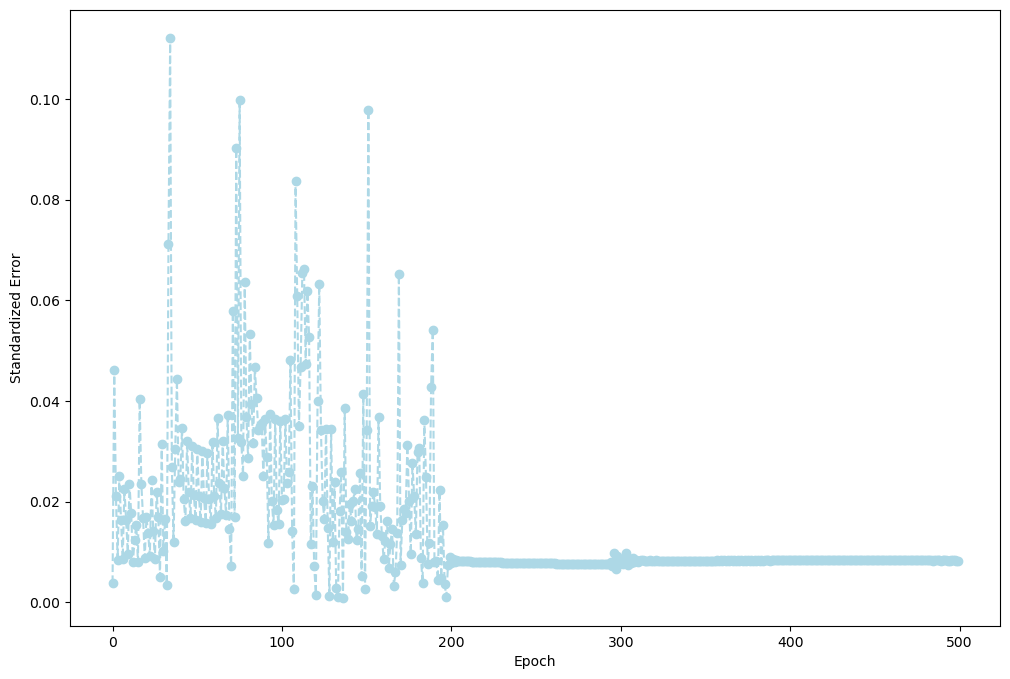

In [60]:
import matplotlib.pyplot as plt

error_trace = [i.cpu().detach().numpy().item() for i in rmse_loss]

plt.subplots(figsize=(12, 8))
plt.plot(error_trace, '--o', color='lightblue')
plt.xlabel('Epoch')
plt.ylabel('Standardized Error')

In [61]:
gw_predicted = nn.predict(train_arr, fips_years_arr, nn_model, train_means, train_stds, obsv_mean, obsv_std)
    
nn.rmse(gw_predicted, observed_arr)

45.334315101223524

In [62]:
# Test Dataset
test_csv = r'F:\WestUS_Wateruse_SpatialDist\data_main\Compiled_data\predictor_csv\test_data.csv'
test_obsv_csv = r'F:\WestUS_Wateruse_SpatialDist\data_main\Compiled_data\predictor_csv\test_obsv.csv'

test_arr, n_inputs, test_obsv_arr, fips_years_arr = nn.create_model_input(test_csv, test_obsv_csv,
                                                     predictor_drop_columns=['fips', 'Year'])

gw_predicted_test = nn.predict(test_arr, fips_years_arr, nn_model, train_means, train_stds, obsv_mean, obsv_std)
    
nn.rmse(gw_predicted_test, test_obsv_arr)

Using predictors: ['GPM_PRECIP', 'MODIS_Day_LST', 'MODIS_NDWI', 'PRISM_PRECIP', 'SSEBOP_ET', 'USDA_cropland_0.0', 'USDA_cropland_1.0', 'USDA_developed_0.0', 'USDA_developed_1.0', 'USDA_developed_2.0', 'USDA_developed_3.0', 'USDA_developed_4.0']


42.569263817830254

In [63]:
# Validation Dataset
val_csv = r'F:\WestUS_Wateruse_SpatialDist\data_main\Compiled_data\predictor_csv\validation_data.csv'
val_obsv_csv = r'F:\WestUS_Wateruse_SpatialDist\data_main\Compiled_data\predictor_csv\validation_obsv.csv'

val_arr, n_inputs, val_obsv_arr, fips_years_arr = nn.create_model_input(val_csv, val_obsv_csv,
                                                     predictor_drop_columns=['fips', 'Year'])

gw_predicted_val = nn.predict(val_arr, fips_years_arr, nn_model, train_means, train_stds, obsv_mean, obsv_std)
    
nn.rmse(gw_predicted_val, test_obsv_arr)

Using predictors: ['GPM_PRECIP', 'MODIS_Day_LST', 'MODIS_NDWI', 'PRISM_PRECIP', 'SSEBOP_ET', 'USDA_cropland_0.0', 'USDA_cropland_1.0', 'USDA_developed_0.0', 'USDA_developed_1.0', 'USDA_developed_2.0', 'USDA_developed_3.0', 'USDA_developed_4.0']


42.569265430077735

## Code to check GPU memory
Got from stackoverflow.

In [37]:
import torch

factor = 9.535675969332089e-07
total_mem = round(torch.cuda.get_device_properties(0).total_memory * factor, 2)
resv_mem = round(torch.cuda.memory_reserved(0) * factor, 2)
alloc_mem = round(torch.cuda.memory_allocated(0) * factor, 2)
free_mem = round(resv_mem - alloc_mem, 2)  # free inside reserved
print(torch.cuda.get_device_properties(0))
print(f'CUDA total memory: {total_mem}MB, reserved memory: {resv_mem}MB')
print(f'allocated memory: {alloc_mem}MB, free memory: {free_mem}MB')

_CudaDeviceProperties(name='NVIDIA GeForce RTX 2060 with Max-Q Design', major=7, minor=5, total_memory=6143MB, multi_processor_count=30)
CUDA total memory: 6143.0MB, reserved memory: 5417.39MB
allocated memory: 3515.77MB, free memory: 1901.62MB


Text(0, 0.5, 'Standardized Error')

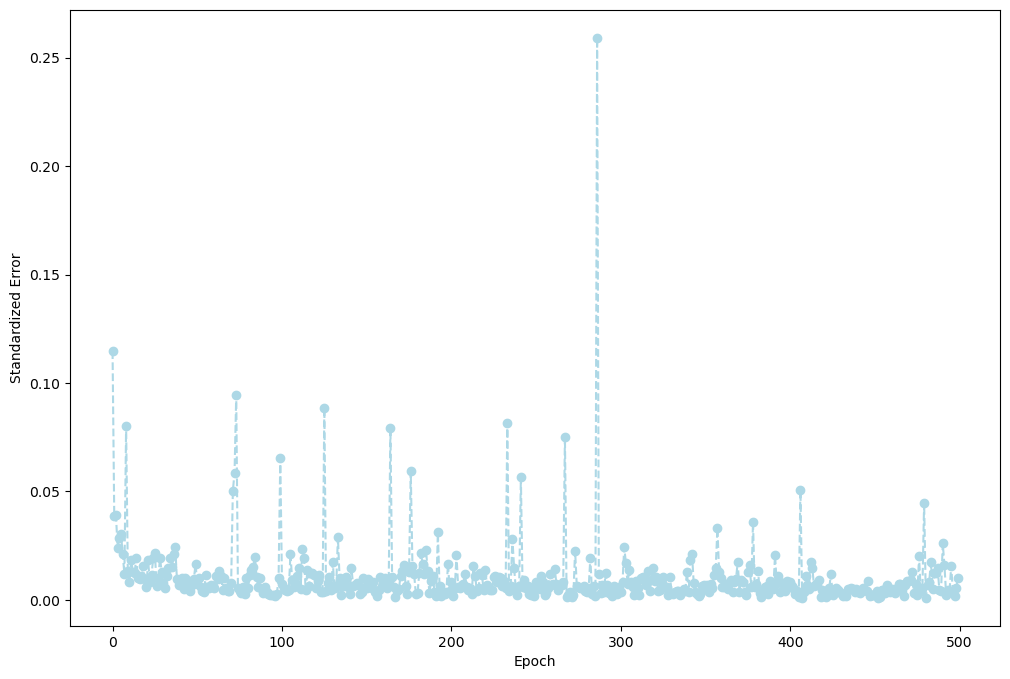

In [106]:
import matplotlib.pyplot as plt

error_trace2 = [i.cpu().detach().numpy().item() for i in rmse2]

plt.subplots(figsize=(12, 8))
plt.plot(error_trace2, '--o', color='lightblue')
plt.xlabel('Epoch')
plt.ylabel('Standardized Error')

#############################################

# Test 1

In [6]:
# nnet.Zs

In [7]:
# nnet.Grads

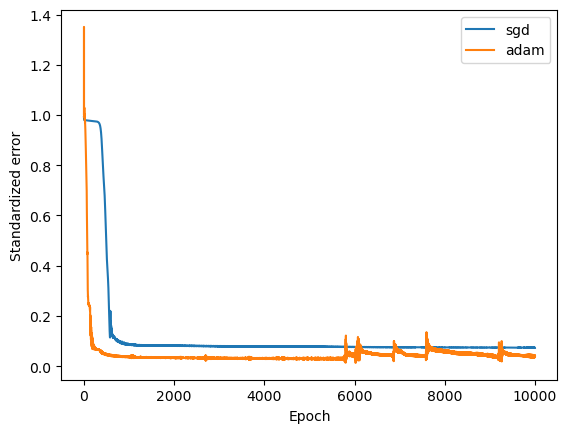

In [11]:
# for error_trace in errors:
#     plt.plot(error_trace)
# plt.xlabel('Epoch')
# plt.ylabel('Standardized error')
# plt.legend([mr[0] for mr in method_rhos]);

In [9]:
import itertools

def partition(X, T, train_fraction):
    """
    Creates train and test datasets.
    
    :param X: 2D numpy array.
              The input variables of the model.
    :param T: 2D numpy array
              The output variable of the model.
    :param X: float
              fraction of data in training set.
              The input variables of the model.
    
    return: Xtrain, Ttrain, Xtest, Ttest
    
    """
    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)

    n_train = round(n_samples * train_fraction)
    Xtrain = X[rows[:n_train], :]
    Ttrain = T[rows[:n_train], :]
    Xtest = X[rows[n_train:], :]
    Ttest = T[rows[n_train:], :]

    return Xtrain, Ttrain, Xtest, Ttest

def rmse(T, Y):
    if isinstance(T, torch.Tensor):
        T = T.numpy()
    return np.sqrt(np.mean((T - Y)**2))

def make_param_grid(structure, rho, epoch):
    """
    Makes a gridspace with all possible combinations of input parameters.
    
    :param structure: list of int
                      Number of units in each hidden layers. Each element of the list represents one hidden layer.
    :param rho: float
                Learning rate of the model.
    :param epoch: int
                  Number of epoch to run the model.
                  
    :return: A list of all parameter combinations.
    """
    param_combs = list(itertools.product(*[structure, rho, epoch]))
    return param_combs


def configure_nnet_model(X, T, structures, rhos, epochs, method, train_test_ratio):
    """
    Runs the model for number of times of parameter combinations and saves model layout, train rmse, and test rmse. 
    
    :param X: 2D numpy array.
              The input variables of the model.
    :param T: 2D numpy array
              The output variable of the model.
    :param structures: A nested list of int, such as [[50, 20], [30, 10]]
                       Number of units in each hidden layers. Each element of the list represents one hidden layer.
    :param rhos: list of float
                 Learning rate of the model.
    :param epochs: list of int
                   Number of epoch to run the model.
    :param method : str
                    Optimization method. Accepted str from - 'sgd', 'adam', or 'scg'.
    :param train_test_ratio: float
                             ratio of dataset in training.
    
    :return: A dataframe with model layouts and respective train test rmse.
    """
    import nn_regression as nn
    
    parameter_combinations = make_param_grid(structures, rhos, epochs)

    Xtrain, Ttrain, Xtest, Ttest = partition(X, T, train_test_ratio)

    n_inputs, n_outputs = Xtrain.shape[1], Ttrain.shape[1]

    result_dict = {'Method': [], 'Structure': [], 'Epochs': [], 'Learning Rate': [], 'Train RMSE': [], 
                   'Test RMSE': []}

    for params in parameter_combinations:
        hidden_layers, rho, epoch = params
        nn_model = nn.NeuralNetwork(n_inputs, hidden_layers, n_outputs, activation_func='tanh', device='cpu')
        nn_model.train(Xtrain, Ttrain, n_epochs=epoch, method=method, learning_rate=rho, verbose=False)
        
        # RMSE (No standardization is required)
        Ttrain_predicted = nn_model.predict(Xtrain)
        rmse_train = rmse(Ttrain_predicted, Ttrain)
        
        Ttest_predicted = nn_model.predict(Xtest)
        rmse_test = rmse(Ttest_predicted, Ttest)
        
        print(f'Training for {method=}, {hidden_layers=}, {rho=}, {epoch=}, train rmse={rmse_train:.2f}, test rmse={rmse_test:.2f}')
        
        # appending results to the result dictionary
        result_dict['Method'].append(method)
        result_dict['Structure'].append(hidden_layers)
        result_dict['Epochs'].append(epoch)
        result_dict['Learning Rate'].append(rho)
        result_dict['Train RMSE'].append(rmse_train)
        result_dict['Test RMSE'].append(rmse_test)

    result_df = pd.DataFrame(result_dict)
    result_df.sort_values(by=['Test RMSE'], axis=0, ascending=True, inplace=True)

    return result_df